In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random
import collections

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

'''
Define a few constants
'''

pi = np.pi
MJUPITER = 1.898e27     #all in SI units
MEARTH = 5.972e24
MSUN = 1.989e30
RJUPITER = 69.911e6
RSUN = 696.34e6
MSATURN = 5.6834e26
BIGG = 6.67e-11
MURANUS = 8.681e25

AU = 1.496e11

REARTH = 6371e3
RNEPTUNE = 24622e3

robinseggblue = '#bfe2ff'    #define a few colors
royalpurple = '#9e00a3'
lavender = '#cc98d9'

In [2]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [3]:
my_file = 'C:/Users/djhoo/Documents/maiasaurus-master/catalogues/file_master.csv'
raw_data = []
with open(my_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        raw_data.append(row)
        
KEYS = raw_data[0]
VALUES = raw_data[1:]

def get_key(keyname, keys = KEYS, values = VALUES):
    '''
    keyname must be a string
    '''
    i = keys.index(keyname)
    arr = []
    for row in values:
        arr.append(row[i])
    return np.array(arr)

In [4]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    if type(s) != list:
        try:
            float(s)
            return True
        except ValueError:
            return False
    else:
        for part in s:
            status = True
            try:
                float(part)
                status = True
            except ValueError:
                status = False
        return status
    
def either_mass_or_radius(masses, radii):
    arr = []
    for i in range(len(masses)):
        if is_number(masses[i]) or is_number(radii[i]):
            arr.append(True)
        else:
            arr.append(False)
    return np.array(arr)
    

d = {}
d['starname'] = get_key('Starname')
print(len(d['starname'][d['starname']=='K00082']))
d['rp'] = get_key('Rp')
d['rs'] = get_key('Rs')
d['mp'] = get_key('Mp')
d['ms'] = get_key('Ms')
d['p'] = get_key('P')
d['disc_method'] = get_key('Detection Method')

legitimate_entries = either_mass_or_radius(d['mp'], d['rp'])
d['starname'] = d['starname'][legitimate_entries == True]
d['rp'] = d['rp'][legitimate_entries == True]
d['rs'] = d['rs'][legitimate_entries == True]
d['mp'] = d['mp'][legitimate_entries == True]
d['ms'] = d['ms'][legitimate_entries == True]
d['p'] = d['p'][legitimate_entries == True]
d['disc_method'] = d['disc_method'][legitimate_entries == True]

d0 = d.copy()

5


In [5]:
def mass_radius(mp): 
    '''
    mp - float or float array
    
    Uses the mass-radius relation given in Chen and Kipping (2016).  This method takes mass and 
    outputs radius.  mp is given in Earth masses, and rp is returned in Earth radii.  The -0.291, 16.580, and -7826.573 
    were calculated using the boundary conditions.
    '''
    mp = float(mp)
    if mp <= 2:                                          
        rp = 10**0.00346*mp**0.2790
    elif mp*MEARTH/MJUPITER <= 0.41:
        rp = 10**-0.0925*mp**0.589
    elif mp*MEARTH/MSUN <= 0.08:
        rp = 10**1.25*mp**-0.044
    else:
        rp = 10**-2.85*mp**0.881
    return rp

for i in range(len(d['mp'])):
    if d['rp'][i] == '' and is_number(d['mp'][i]) == True:
        d['rp'][i] = mass_radius(d['mp'][i])
        
def radius_mass(rp):
    '''
    If rp is an individual number, function will return an individual number for mp.
    If rp is a list, function will return a list for mp.
    
    Takes a radius measurement and outputs its corresponding mass using the mass-radius relation in Chen and Kipping
    (2016).  This is kind of like the inverse of mass_radius above.
    '''
    rp = float(rp)
    if rp < 1.23:
        mp = 10**((np.log10(rp)-0.00346)/0.2790)
    elif rp <= 11.1:
        mp = 10**((np.log10(rp)+0.0925)/0.589)
    elif rp >= 14.3:
        mp = 10**((np.log10(rp)+2.85)/0.881)
    else:
        mp = 0
    return mp

for i in range(len(d['rp'])):
    if d['mp'][i] == '' and is_number(d['rp'][i]) == True:
        d['mp'][i] = radius_mass(d['rp'][i])

In [6]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

total number of queried objects = 4999
after removing missing data, number of objects = 3881


In [7]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [8]:
def check_uniformity(detection_methods):
    method = detection_methods[0]
    uniformity = True
    for i in range(len(detection_methods)):
        if detection_methods[i] != method:
            uniformity = False
    return uniformity

def positivity_condition(value):
    if type(value) != list:
        if value > 0:
            return True
    else:
        for v in value:
            status = True
            if v <= 0 or v == 0.:
                status = False
        return status

def conditions(star_mass, radius, star_radius, mass, period):
    if is_number(star_mass) and is_number(radius) and is_number(star_radius) and is_number(mass) and is_number(period):
        if positivity_condition(star_mass) and positivity_condition(radius) and positivity_condition(star_radius) \
        and positivity_condition(mass) and positivity_condition(period):
            return True
    else:
        return False

uniquesys = np.unique(d['starname'])
systems   = []

masses = []
radii = []
periods = []
starnames = []
detection_methods = []

for us in uniquesys:
    s = System()
    
    s.sysid = us
    s.starname = d['starname'][d['starname']==us][0]
    s.Mstar = d['ms'][d['starname']==us][0]
    s.Rstar = d['rs'][d['starname']==us][0]
    
    s.masses = d['mp'][d['starname']==us]
    s.radii = d['rp'][d['starname']==us]
    s.detection_methods = d['disc_method'][d['starname']==us]
    s.periods = d['p'][d['starname']==us]
    
    if len(s.masses) > 1 and check_uniformity(s.detection_methods) == True:
        if conditions(s.Mstar, s.radii.tolist(), s.Rstar, s.masses.tolist(), s.periods.tolist()) == True:
    
            order = np.argsort(s.periods)

            s.masses = s.masses[order]
            s.detection_method = s.detection_methods[0]
            s.periods = s.periods[order]
            s.radii = s.radii[order]
            
            masses.append(s.masses)
            radii.append(s.radii)
            periods.append(s.periods)
            starnames.append(s.starname)
            detection_methods.append(s.detection_method)
            
            s.N = len(s.masses)
            s.Q = archinfo.Q(s.masses)
            s.mu = archinfo.mu(s.masses, s.Mstar)
            s.M = archinfo.M(s.periods, s.masses)
            s.S = archinfo.S(s.periods, s.masses, s.Mstar)
            s.C = archinfo.C(s.periods)

            systems.append(s)

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:186: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2530: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\djhoo\Miniconda3\lib\site-packages\numpy\lib\function_base.py:2531: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\djhoo\Miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  co

In [9]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
Mstar = np.zeros(Nsys)
Rstar = np.zeros(Nsys)
logmu_over_N = np.zeros(Nsys)


for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    Mstar[i] = s.Mstar
    Rstar[i] = s.Rstar
    logmu_over_N[i] = np.log10(s.mu/s.N)

logmu = np.log10(mu)


Q = Q[N >= 3]
M = M[N >= 3]
S = S[N >= 3]
C = C[N >= 3]
Mstar = Mstar[N >= 3]
Rstar = Rstar[N >= 3]
logmu = logmu[N >= 3]
mu = mu[N >= 3]
logmu_over_N = logmu_over_N[N >= 3]

sv_masses = []
sv_radii = []
sv_periods = []
sv_starnames = []
sv_detection_methods = []
for i in range(len(N)):
    if N[i] >= 3:
        sv_masses.append(masses[i])
        sv_radii.append(radii[i])
        sv_periods.append(periods[i])
        sv_starnames.append(starnames[i])
        sv_detection_methods.append(detection_methods[i])
masses = sv_masses
radii = sv_radii
periods = sv_periods
starnames = sv_starnames
detection_methods = sv_detection_methods
N = N[N >= 3]

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


47 UMa 0.00436498643480545 [804.07568654 171.62089752 521.2190221 ]
55 Cnc 0.0052934792677867635 [   8.07889484  263.97836571   54.47374414   44.81212324 1232.49229739]
61 Vir 0.00014724459593400054 [ 5.08506363 18.11553918 22.88278634]
DMPP-1 0.00010262608444543107 [ 3.34978567  4.12843603  9.5980576  24.26846618]
GJ 1061 0.00011884162111831781 [1.36978902 1.73845613 1.63993302]
GJ 3138 7.270030188657783e-05 [ 1.77977227  4.17928667 10.5006564 ]
GJ 3293 0.00039693419637242694 [ 3.27986604 23.53748828  7.59899196 21.09030141]
GJ 581 0.00022262596727178072 [ 1.68442733 15.7954789   5.49822505]
GJ 676 A 0.015428423695604683 [   4.44943068    7.94541192 1576.36972539 2161.15204287]
GJ 876 0.009118350086206673 [  6.67414601 226.9845278  723.22317482  14.61955794]
HD 10180 0.00046097617527064396 [13.22116544 12.01346283 25.58422639 22.94634963 23.26416611 65.66088413]
HD 125612 0.008973640988238694 [  17.47990623  985.23107837 2313.70395177]
HD 158259 7.07693634013365e-05 [2.21835901 5.5999

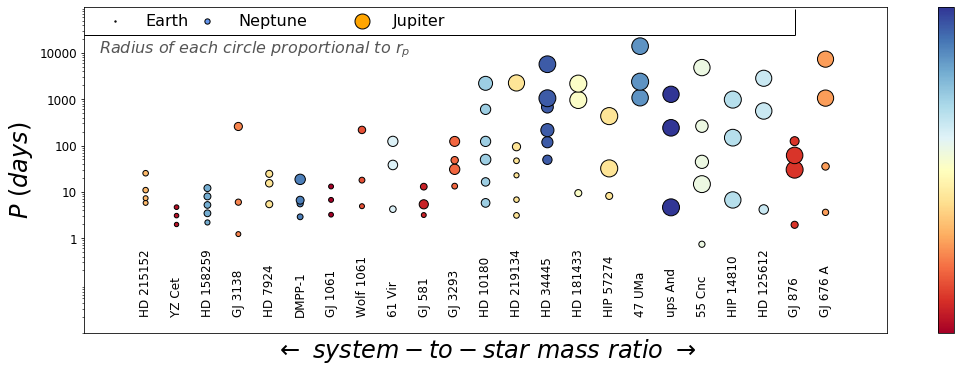

In [10]:
mu_rv = []
masses_rv = []
periods_rv = []
radii_rv = []
Rstar_rv = []
starnames_rv = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        mu_rv.append(mu[i])
        periods_rv.append(periods[i])
        masses_rv.append(masses[i])
        radii_rv.append(radii[i])
        Rstar_rv.append(Rstar[i])
        starnames_rv.append(starnames[i])
        print(starnames[i] + " " + str(mu[i]) + " " + str(masses[i]))

mu_rank = np.array(stats.rankdata(mu_rv), dtype = 'int')
mu_pos = []
for i in range(len(masses_rv)):
    for j in range(len(masses_rv[i])):
        mu_pos.append(mu_rank[i])

cm = plt.cm.get_cmap('RdYlBu')


rs_final = []
for i in range(len(masses_rv)):
    arr = []
    for j in range(len(masses_rv[i])):
        arr.append(Rstar_rv[i])
    rs_final.append(arr)
    

rs_rank = np.array(stats.rankdata([item for sublist in rs_final for item in sublist])-1, dtype = 'int')

plt.figure(figsize = (18, 6))
plt.tight_layout()

plt.scatter(mu_pos, [item for sublist in periods_rv for item in sublist], c = rs_rank, cmap = cm, \
s = 225*REARTH/RJUPITER*np.array([item for sublist in radii_rv for item in sublist]), edgecolors = 'black')
cbar = plt.colorbar()
plt.clim(min(rs_rank), max(rs_rank))
cbar.set_ticks([])

for i in range(len(radii_rv)):
    plt.text(mu_rank[i]-0.2, 0.02, starnames_rv[i], rotation = 90, va = 'bottom', fontsize = 12)

plt.xticks([])
plt.xlabel(r'$\leftarrow\ system-to-star\ mass\ ratio\ \rightarrow$', fontsize=24)

plt.ylabel(r'$P\ (days)$', fontsize=24)

plt.xlim(-1, max(mu_pos)+2)

plt.yscale('log')
plt.yticks([1, 10, 100, 1000, 10000], [1, 10, 100, 1000, 10000], fontsize = 12)

plt.ylim(0.009, 100000)

plt.hlines(25000, -1, 22, lw = 1)
plt.vlines(22, 25000, 90000, lw = 1)
plt.plot(0, 50000, 'o', markersize=15*REARTH/RJUPITER, color='lightgrey', mec='k', mew=1)
plt.text(1, 50000, 'Earth', va='center', fontsize=16)
plt.plot(3, 50000, 'o', markersize=15*RNEPTUNE/RJUPITER, color='cornflowerblue', mec='k', mew=1)
plt.text(4, 50000, 'Neptune', va='center', fontsize=16)
plt.plot(8, 50000, 'o', markersize=15*RJUPITER/RJUPITER, color='orange', mec='k', mew=1)
plt.text(9, 50000, 'Jupiter', va='center', fontsize=16)

plt.text(-0.5,20000, r'$Radius\ of\ each\ circle\ proportional\ to\ r_p$', \
         fontsize=16, color='#555555', va='top')
plt.show()

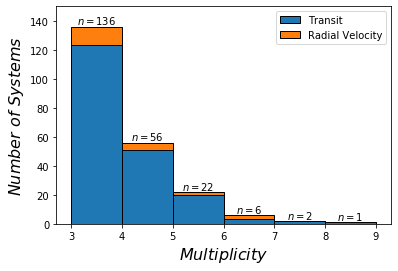

In [11]:
'''
Making a histogram of combined star systems' multiplicities.  No divisions were made based on stellar masses or 
detection methods.
'''
plt.ylim(0, 150)
plt.ylabel(r'$Number\ of\ Systems$', fontsize=16)
plt.xlabel(r'$Multiplicity$', fontsize=16)               #making a histogram

n = np.array([[1, 2, 3], [1, 2]])
for i in range(len(N)):
    if detection_methods[i] == 'Transit':
        n[0].append(N[i])
    elif detection_methods[i] == 'Radial Velocity':
        n[1].append(N[i])
N_transit = np.array(n[0])
N_rv = np.array(n[1])
plt.hist(n, bins = np.arange(3, 10, 1), edgecolor = 'k', histtype='bar', stacked=True, label=['Transit', 'Radial Velocity'])
plt.legend(loc='upper right')
for i in range(3, 9):
    plt.text(i+0.5, np.sum(N_transit==i)+np.sum(N_rv==i), \
            r'$n = %d$' %(np.sum(N_transit==i)+np.sum(N_rv==i)), \
            va = 'bottom', ha = 'center', fontsize=10)
plt.xticks([3, 4, 5, 6, 7, 8, 9])
plt.show()

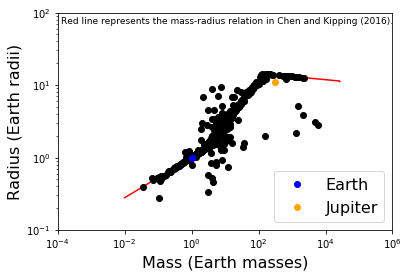

In [12]:
mp = np.array([item for sublist in masses for item in sublist])
rp = np.array([item for sublist in radii for item in sublist])

x = np.linspace(0.01, 2, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

x = np.linspace(2, 0.41*MJUPITER/MEARTH, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

x = np.linspace(0.41*MJUPITER/MEARTH, 0.08*MSUN/MEARTH, 100).tolist()
y = [mass_radius(i) for i in x]
plt.plot(x, y, '-r')

plt.plot(mp, rp, 'o', color='black')
                                                                                    #add in Earth and Jupiter for reference
plt.plot(1, 1, 'o', color='blue', label='Earth')                                                 #Earth
plt.plot(MJUPITER/MEARTH, RJUPITER/REARTH, 'o', color='orange', label='Jupiter')                 #Jupiter

plt.xlabel('Mass (Earth masses)', fontsize=16)
plt.xscale("log")
plt.xlim(10**-4, 10**6)
plt.ylabel('Radius (Earth radii)', fontsize=16)
plt.yscale("log")
plt.ylim(10**-1, 10**2)
plt.text(10**-3.9, 70, 'Red line represents the mass-radius relation in Chen and Kipping (2016).', fontsize=9)

plt.legend(loc='lower right', fontsize=16)

'''
There are a couple RV planets whose radii are already known.
'''

plt.show()

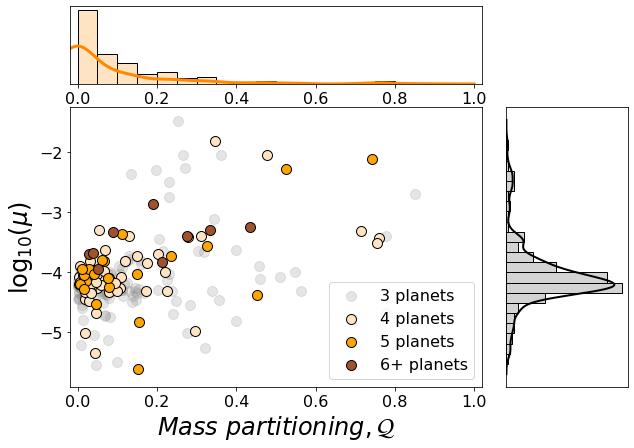

In [13]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q[N==5], logmu[N==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q[N>=6], logmu[N>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

# Q historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-Q,Q])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(Q, bins=np.arange(0,1,0.05), density=True, color='bisque', edgecolor='k')
ax1h.plot(x, y, c='#ff8800', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu,bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_xticks([])
ax1h.tick_params(labelsize=16)

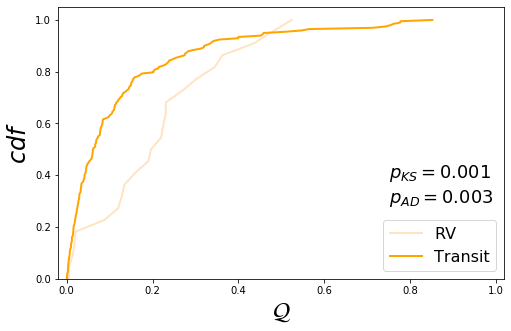

In [14]:
#Q cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))
Q_rv = []
Q_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        Q_rv.append(Q[i])
    elif detection_methods[i] == 'Transit':
        Q_transit.append(Q[i])
Q_rv = np.array(Q_rv)
Q_transit = np.array(Q_transit)
Q_rv = np.sort(np.squeeze(Q_rv))
Q_transit = np.sort(np.squeeze(Q_transit))

KS = np.array(stats.ks_2samp(Q_rv, Q_transit))[1]
AD = stats.anderson_ksamp([Q_rv, Q_transit])[2]

ax.plot(Q_rv, np.linspace(0,1,len(Q_rv)), lw=2, color='bisque', label='RV')
ax.plot(Q_transit, np.linspace(0,1,len(Q_transit)), lw=2, color='orange', label='Transit')

ax.set_xlim(-0.02,1.02)
ax.set_xlabel(r'$\mathcal{Q}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(0.75, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(0.75, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.show()

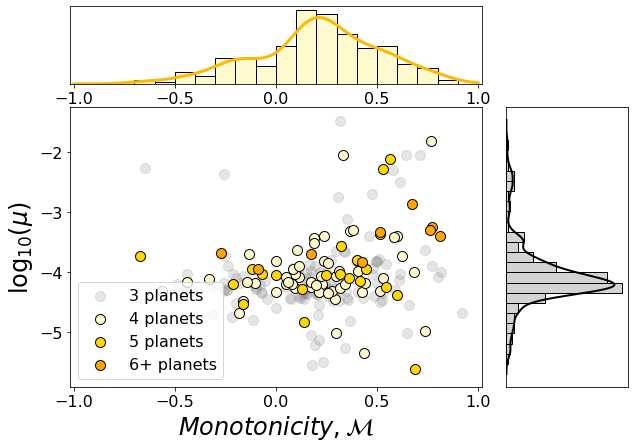

In [15]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M[N==5], logmu[N==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M[N>=6], logmu[N>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1.02,1.02)
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower left',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# M historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack(M)).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(M, bins=np.arange(-1,1,0.1), density=True, color='lemonchiffon', edgecolor='k')
ax1h.plot(x, y, c='#fcba03', lw=3)
ax1h.set_xlim(-1.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu,bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: p-value floored: true value smaller than 0.001
  app.launch_new_instance()


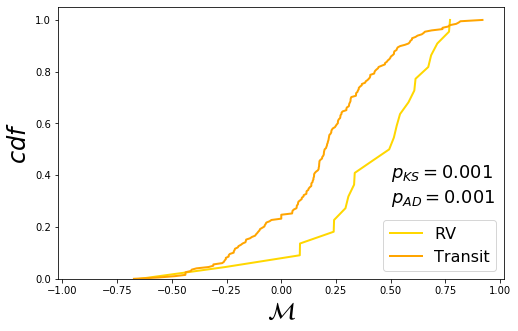

In [16]:
#M cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))
M_rv = []
M_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        M_rv.append(M[i])
    elif detection_methods[i] == 'Transit':
        M_transit.append(M[i])
M_rv = np.array(M_rv)
M_transit = np.array(M_transit)
M_rv = np.sort(np.squeeze(M_rv))
M_transit = np.sort(np.squeeze(M_transit))

KS = np.array(stats.ks_2samp(M_rv, M_transit))[1]
AD = stats.anderson_ksamp([M_rv, M_transit])[2]

ax.plot(M_rv, np.linspace(0,1,len(M_rv)), lw=2, color='gold', label='RV')
ax.plot(M_transit, np.linspace(0,1,len(M_transit)), lw=2, color='orange', label='Transit')

ax.set_xlim(-1.02,1.02)
ax.set_xlabel(r'$\mathcal{M}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(0.5, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(0.5, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.show()

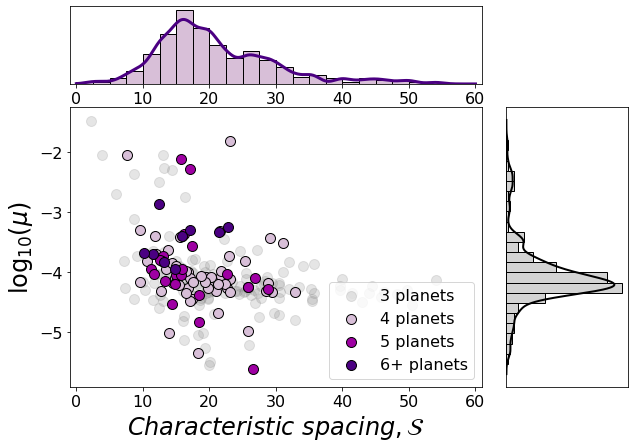

In [17]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S[N==5], logmu[N==5], c=royalpurple, edgecolor='k', s=100, label='5 planets')
ax1.scatter(S[N>=6], logmu[N>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-1,61)
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# S historgram
x = np.linspace(0,60,1000)
y = FFTKDE(kernel='gaussian', bw='ISJ').fit(S).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(S, bins=np.arange(0.0,55.0,2.5), color='thistle', edgecolor='black', density=True)
ax1h.plot(x, y, lw=3, c='indigo')
ax1h.set_yticks([])
ax1h.set_xlim(-1,61)
ax1h.tick_params(labelsize=16)

# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu,bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.show()

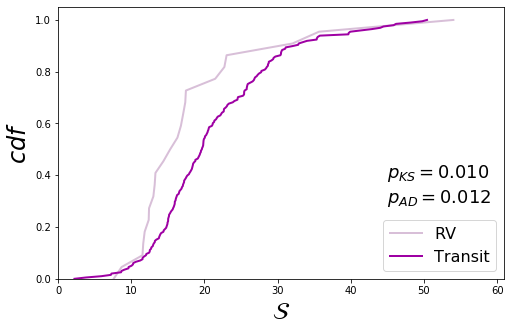

In [18]:
#S cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))
S_rv = []
S_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        S_rv.append(S[i])
    elif detection_methods[i] == 'Transit':
        S_transit.append(S[i])
S_rv = np.array(S_rv)
S_transit = np.array(S_transit)
S_rv = np.sort(np.squeeze(S_rv))
S_transit = np.sort(np.squeeze(S_transit))

KS = np.array(stats.ks_2samp(S_rv, S_transit))[1]
AD = stats.anderson_ksamp([S_rv, S_transit])[2]

ax.plot(S_rv, np.linspace(0,1,len(S_rv)), lw=2, color='thistle', label='RV')
ax.plot(S_transit, np.linspace(0,1,len(S_transit)), lw=2, color=royalpurple, label='Transit')

ax.set_xlim(0,61)
ax.set_xlabel(r'$\mathcal{S}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(45, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(45, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.show()

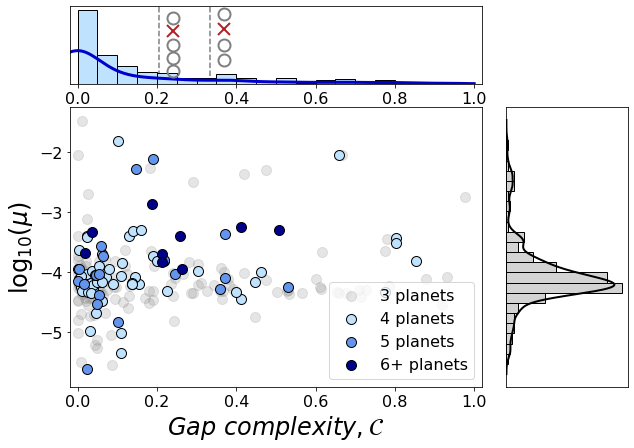

In [26]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C[N==4], logmu[N==4], c=robinseggblue, edgecolor='k', s=100, label='4 planets')
ax1.scatter(C[N==5], logmu[N==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C[N>=6], logmu[N>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


# C historgram
x = np.linspace(-1,1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(np.hstack([-C,C])).evaluate(x)

ax1h = plt.subplot2grid((4,4),(0,0),colspan=3,rowspan=1)
ax1h.hist(C, bins=np.arange(0,1,0.05), density=True, color=robinseggblue, edgecolor='k')
ax1h.plot(x,y, c='mediumblue', lw=3)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])

# 4- and 5-planet systems with second-to-last planet removed
P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

ax1h.axvline(C43, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.37,0.37,0.37], [2.4,3.9,6.9], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.37], [5.4], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)

ax1h.axvline(C54, color='grey', linestyle='--', zorder=0)
ax1h.plot([0.24,0.24,0.24,0.24], [1.3,2.6,3.9,6.5], 'o', c='grey', ms=12, fillstyle='none', mew=2)
ax1h.plot([0.24], [5.2], 'x', c='firebrick', ms=12, mew=2)
ax1h.set_xlim(-0.02,1.02)
ax1h.set_yticks([])
ax1h.tick_params(labelsize=16)


# mu historgram
x = np.linspace(-6.0,-1,1000)
y = FFTKDE(kernel='gaussian', bw='silverman').fit(logmu).evaluate(x)

axsh = plt.subplot2grid((4,4),(1,3),colspan=1,rowspan=3)
axsh.hist(logmu,bins=np.arange(-6,-1,0.2), density=True, \
         orientation='horizontal',color='lightgrey',edgecolor='black')
axsh.plot(y, x, lw=2, c='k')
axsh.set_yticks([])
axsh.set_xticks([])
axsh.tick_params(labelsize=16)

plt.show()

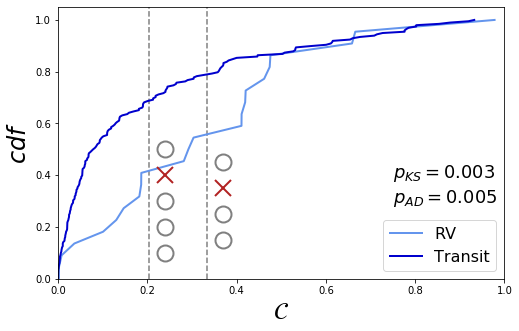

In [20]:
#C cdf between transit and RV data
fix, ax = plt.subplots(1, figsize = (8, 5))
C_rv = []
C_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        C_rv.append(C[i])
    elif detection_methods[i] == 'Transit':
        C_transit.append(C[i])
C_rv = np.array(C_rv)
C_transit = np.array(C_transit)
C_rv = np.sort(np.squeeze(C_rv))
C_transit = np.sort(np.squeeze(C_transit))

KS = np.array(stats.ks_2samp(C_rv, C_transit))[1]
AD = stats.anderson_ksamp([C_rv, C_transit])[2]

ax.plot(C_rv, np.linspace(0,1,len(C_rv)), lw=2, color='cornflowerblue', label='RV')
ax.plot(C_transit, np.linspace(0,1,len(C_transit)), lw=2, color='mediumblue', label='Transit')

ax.set_xlim(0,1)
ax.set_xlabel(r'$\mathcal{C}$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

plt.vlines(C43,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.37,0.37,0.37], [0.15,0.25,0.45], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.37, 0.35, 'x', c='firebrick', ms=16, mew=2)

plt.vlines(C54,0,1.05, color='grey', linestyle='--', zorder=0)
plt.plot([0.24,0.24,0.24,0.24], [0.1,0.2,0.3,0.5], 'o', c='grey', ms=16, fillstyle='none', mew=2)
plt.plot(0.24, 0.4, 'x', c='firebrick', ms=16, mew=2)

ax.text(0.75, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(0.75, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.show()

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: p-value floored: true value smaller than 0.001
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: p-value floored: true value smaller than 0.001


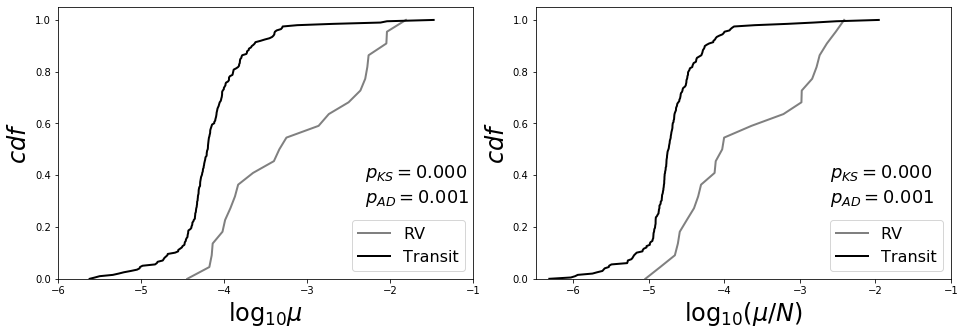

In [21]:
#logmu cdf between transit and RV data
fix, axes = plt.subplots(1, 2, figsize = (16, 5))
plt.subplots_adjust(wspace=0.15)
logmu_rv = []
logmu_transit = []
logmu_over_N_rv = []
logmu_over_N_transit = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Radial Velocity':
        logmu_rv.append(logmu[i])
        logmu_over_N_rv.append(logmu_over_N[i])
    elif detection_methods[i] == 'Transit':
        logmu_transit.append(logmu[i])
        logmu_over_N_transit.append(logmu_over_N[i])
logmu_rv = np.array(logmu_rv)
logmu_transit = np.array(logmu_transit)
logmu_rv = np.sort(np.squeeze(logmu_rv))
logmu_transit = np.sort(np.squeeze(logmu_transit))
logmu_over_N_rv = np.array(logmu_over_N_rv)
logmu_over_N_transit = np.array(logmu_over_N_transit)
logmu_over_N_rv = np.sort(np.squeeze(logmu_over_N_rv))
logmu_over_N_transit = np.sort(np.squeeze(logmu_over_N_transit))

ax = axes[0]

KS = np.array(stats.ks_2samp(logmu_rv, logmu_transit))[1]
AD = stats.anderson_ksamp([logmu_rv, logmu_transit])[2]

ax.plot(logmu_rv, np.linspace(0,1,len(logmu_rv)), lw=2, color='grey', label='RV')
ax.plot(logmu_transit, np.linspace(0,1,len(logmu_transit)), lw=2, color='black', label='Transit')

ax.set_xlim(-6,-1)
ax.set_xlabel(r'$\log_{10}\mu$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(-2.3, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(-2.3, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

ax = axes[1]

KS = np.array(stats.ks_2samp(logmu_over_N_rv, logmu_over_N_transit))[1]
AD = stats.anderson_ksamp([logmu_over_N_rv, logmu_over_N_transit])[2]

ax.plot(logmu_over_N_rv, np.linspace(0,1,len(logmu_over_N_rv)), lw=2, color='grey', label='RV')
ax.plot(logmu_over_N_transit, np.linspace(0,1,len(logmu_over_N_transit)), lw=2, color='black', label='Transit')

ax.set_xlim(-6.5,-1)
ax.set_xlabel(r'$\log_{10}(\mu/N)$', fontsize=24)
ax.set_ylim(0,1.05)
ax.set_ylabel(r'$cdf$', fontsize=24)

ax.legend(loc='lower right', fontsize=16)

ax.text(-2.6, 0.45, r'$p_{KS} = %.3f$' %KS, fontsize=18, ha='left', va='top')
ax.text(-2.6, 0.35, r'$p_{AD} = %.3f$' %AD, fontsize=18, ha='left', va='top')

plt.show()

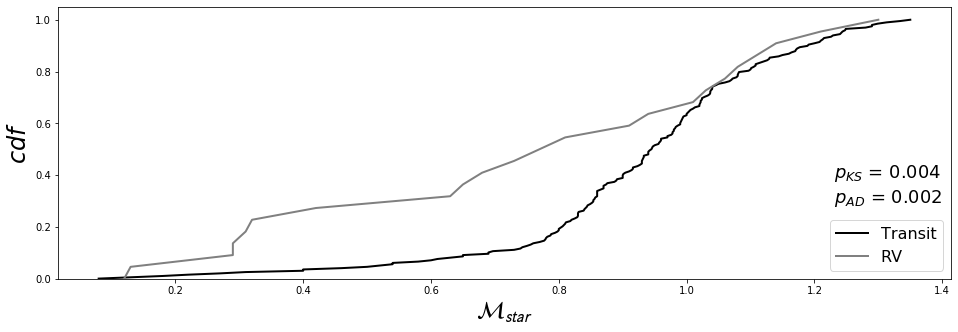

In [22]:
ms_transit = []
ms_rv = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Transit':
        ms_transit.append(Mstar[i])
    elif detection_methods[i] == 'Radial Velocity':
        ms_rv.append(Mstar[i])
ms_transit = np.sort(np.squeeze(ms_transit))
ms_rv = np.sort(np.squeeze(ms_rv))

KS = np.array(stats.ks_2samp(ms_rv, ms_transit))[1]
AD = stats.anderson_ksamp([ms_rv, ms_transit])[2]

plt.figure(figsize=(16,5))
plt.plot(ms_transit, np.linspace(0, 1, len(ms_transit)), lw=2, color='black', label='Transit')
plt.plot(ms_rv, np.linspace(0, 1, len(ms_rv)), lw=2, color='grey', label='RV')
plt.text(1.23, 0.45, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
plt.text(1.23, 0.35, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
plt.xlabel(r'$\mathcal{M}_{\mathcal{star}}$', fontsize=24)
plt.ylim(0, 1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)

plt.show()

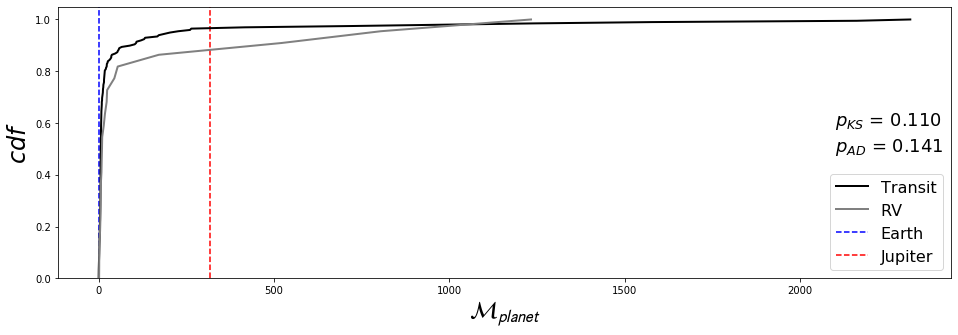

In [23]:
mp = [item for sublist in masses for item in sublist]

mp_transit = []
mp_rv = []
for i in range(len(detection_methods)):
    if detection_methods[i] == 'Transit':
        mp_transit.append(mp[i])
    elif detection_methods[i] == 'Radial Velocity':
        mp_rv.append(mp[i])
mp_transit = np.sort(np.squeeze(mp_transit))
mp_rv = np.sort(np.squeeze(mp_rv))

KS = np.array(stats.ks_2samp(mp_rv, mp_transit))[1]
AD = stats.anderson_ksamp([mp_rv, mp_transit])[2]

plt.figure(figsize=(16,5))
plt.plot(mp_transit, np.linspace(0, 1, len(mp_transit)), lw=2, color='black', label='Transit')
plt.plot(mp_rv, np.linspace(0, 1, len(mp_rv)), lw=2, color='grey', label='RV')
plt.axvline(MEARTH/MEARTH, color='blue', linestyle='--', zorder=0, label='Earth')
plt.axvline(MJUPITER/MEARTH, color='red', linestyle='--', zorder=1, label = 'Jupiter')
plt.text(2100, 0.65, r'$p_{KS}$ = %.3f' %KS, fontsize=18, ha='left', va='top')
plt.text(2100, 0.55, r'$p_{AD}$ = %.3f' %AD, fontsize=18, ha='left', va='top')
plt.xlabel(r'$\mathcal{M}_{\mathcal{planet}}$', fontsize=24)
plt.ylim(0, 1.05)
plt.ylabel(r'$cdf$', fontsize=24)
plt.legend(loc='lower right', fontsize=16)

plt.show()